In [59]:
from scipy.stats import binom, poisson, norm, lognorm
import matplotlib.pyplot as plt
from iminuit import Minuit        # The actual fitting tool, better than scipy's
from scipy import stats
import sympy as sy
import numpy as np
import math
import sys

sys.path.append(r'/home/saim/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax

In [60]:
# Plotting stuff

plt.rcParams['font.size'] = 18 
plt.style.use(['science', 'notebook', 'grid'])

pink = '#e377c2'
blue = '#1f77b4'
golden = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
purple = '#9467bd'
light_blue = '#17becf'

In [61]:
r = np.random
r.seed(42)

In [62]:
def chi2_eval(fitted_object, Npoints, Nparams):
    
    Chi2_value = fitted_object.fval
    Ndof = Npoints - Nparams   # Number of degrees of freedom
    Chi2_prob = stats.chi2.sf(Chi2_value, Ndof)

    return Chi2_value, Ndof, Chi2_prob

In [63]:
# Turning histogram data into x, y, and sigma_y values for all non-zero entries (not considered in Chi2 fit):
def hist_data(data, Nbins, mini, maxi):
    
    counts, bin_edges = np.histogram(data, 
                                     bins = Nbins, 
                                     range = (mini, maxi), 
                                     density = False)

    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    x = bin_centers[counts > 0]

    y = counts[counts > 0]
    sy = np.sqrt(y)
    
    return x, y, sy

In [64]:
def draw_chi2fit(Nparams, x_values, x_min, x_max, PDF, 
                 fitted_dist, Nbins, x_bin, y_bin, sigma):
    
    # Produce the points for drawing the fit:
    x_axis = np.linspace(x_min, x_max, Nbins)
    y_axis = PDF(x_axis, *fitted_dist.values[:]
                      )

# Produce figure with histogram (with error bars) and fit overlayed:
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.errorbar(x_bin, y_bin, sigma, fmt = '.', color = '#1f77b4', label = 'Data')
    ax.plot(x_axis, y_axis, '-', color = golden, label = 'Fit')

    ax.set(xlabel = "Value", 
           ylabel = "Frequency", 
           title = "")

    ax.legend(loc = 'lower right', 
              fontsize=14);
    

    # Fitting results
    chi2_value = fitted_dist.fval
    Ndof = Nbins - fitted_dist.nfit
    chi2_prob = stats.chi2.sf(chi2_value, Ndof)


# Define figure text
    d = {'Entries': len(x_values),
         'Chi2':       chi2_value,
         'ndf':        Ndof,
         'Prob':       chi2_prob,
    }

    
    for name in fitted_dist.parameters:
        d[name] = [fitted_dist.values[name], fitted_dist.errors[name]]
    
    text = nice_string_output(d, extra_spacing = 2, decimals = 3)
    add_text_to_ax(0.69, 0.95, text, ax, fontsize = 15)
    fig.tight_layout()

## Gaussian chi2 fit

In [65]:
Npointz = 10000     # Number of random points produced
x_all = r.normal(loc = 0.2, 
                 scale = 1.1, 
                 size = Npointz)

Nbinz = 100
xmin, xmax = np.min(x_all), np.max(x_all)
binwidth_gauss = np.ptp(x_all) / Nbinz
#binwidth = (xmax - xmin) / Nbins

# Fitting function which is NOT normalised but has normalisation constants "N" in, 
# and includes the bin width:
def func_gauss_norm(x, N, mu, sigma) :
    norm = binwidth_gauss * N / np.sqrt(2.0 * np.pi) / sigma
    z = (x - mu) / sigma
    return norm * np.exp(-0.5 * (z**2))

def func_gaussian_alt(x, N, mu, sigma) :
    return binwidth_gauss * N * norm.pdf(x, mu, sigma)

In [66]:
x1, y1, sy1 = hist_data(x_all, Nbinz, xmin, xmax)

In [67]:
# Fitting
chi2_gaussian = Chi2Regression(func_gauss_norm, x1, y1, sy1)     # Fitting object
chi2_gaussian.errordef = Minuit.LEAST_SQUARES

minuit_gaussian = Minuit(chi2_gaussian, 
                         N = Npointz, 
                         mu = 0, 
                         sigma = 0.05)

minuit_gaussian.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 75.35                      │        Nfcn = 196 (196 total)        │
│ EDM = 2.32e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  9.93e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ mu    │   0.199   │   0.011   │            │            │         │         │       │
│ 2 │ sigma │   1.094   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

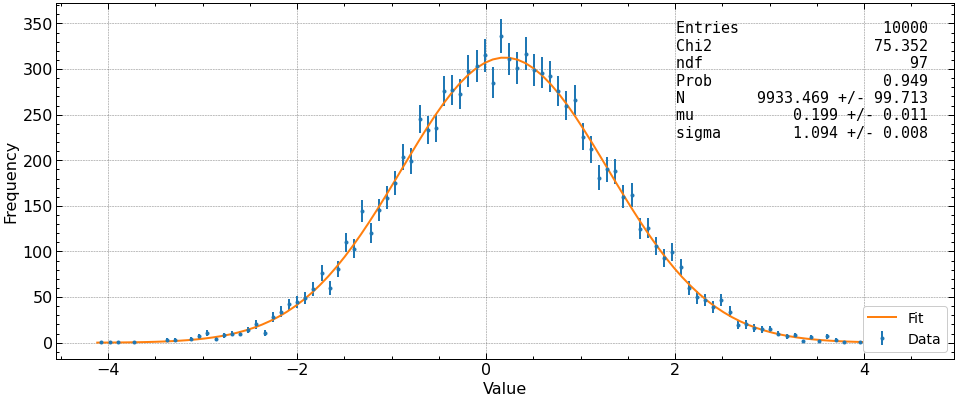

In [68]:
draw_chi2fit(3, x_all, xmin, xmax, func_gauss_norm, 
             minuit_gaussian, Nbinz, x1, y1, sy1)

## Linear chi2 fit

In [69]:
# Fitting function
def func_linear(x, alpha0, alpha1):
        return alpha0 + alpha1*x

In [70]:
# Parameters
alpha0 = 3.6
alpha1 = 0.3
sigma_y = 0.5

In [71]:
lin_Npoints = 50                        # Number of random points produced
lin_x = np.arange(lin_Npoints)               # Generate points in array
#exLin = np.zeros_like(lin_x)

lin_y = alpha0 + alpha1 * lin_x + r.normal(0, sigma_y, lin_Npoints)    # linear function + gaussian errors
error_lin_y = sigma_y * np.ones_like(lin_x)

In [72]:
# Fitting
chi2_linear = Chi2Regression(func_linear, lin_x, lin_y, error_lin_y)   # Fitting object
chi2_linear.errordef = Minuit.LEAST_SQUARES

# Give fitting function, its parameters their starting fitting values
minuit_linear = Minuit(chi2_linear, 
                         alpha0 = 2, 
                         alpha1 = 0.1)

minuit_linear.migrad()  # perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 37.08                      │         Nfcn = 32 (32 total)         │
│ EDM = 1.82e-21 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha0 │   3.63    │   0.14    │            │            │         │         │       │
│ 1 │ alpha1 │   0.301   │   0.005   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [73]:
chi2_linear, Ndof_linear, pval_linear = chi2_eval(minuit_linear, len(lin_x), 2)

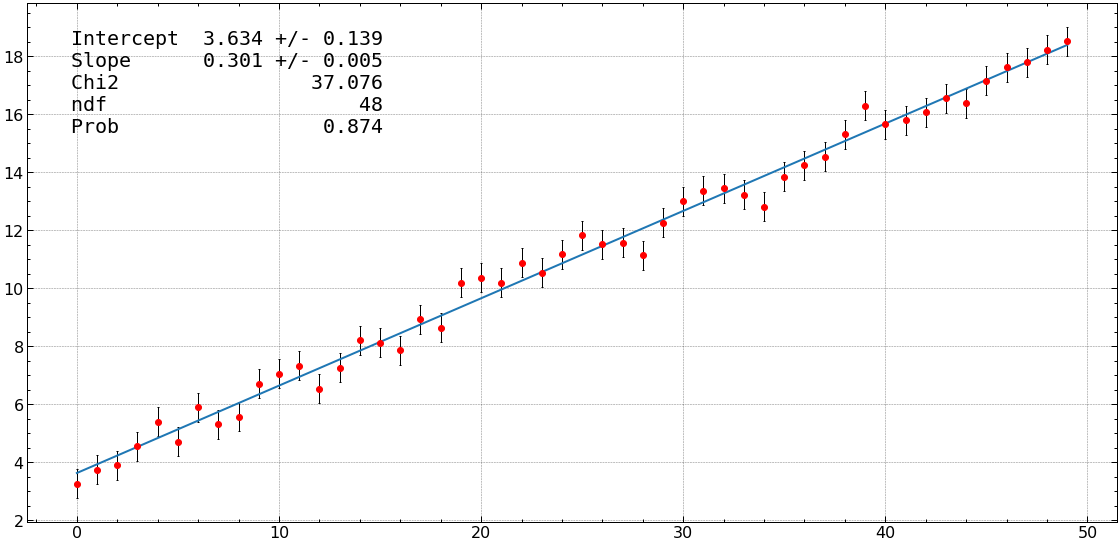

In [74]:
figLin, axLin = plt.subplots(figsize=(16, 8))

axLin.errorbar(lin_x, 
               lin_y, 
               error_lin_y, 
               fmt = 'ro', 
               ecolor = 'k', 
               elinewidth = 1, 
               capsize = 1, 
               capthick = 1)

axLin.plot(lin_x, 
           func_linear(lin_x, *minuit_linear.values[:]), 
           '-r', 
           color = blue)

d = {'Intercept':[minuit_linear.values['alpha0'], minuit_linear.errors['alpha0']],
     'Slope':    [minuit_linear.values['alpha1'], minuit_linear.errors['alpha1']],
     'Chi2':     chi2_linear,
     'ndf':      Ndof_linear,
     'Prob':     pval_linear,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text, axLin, fontsize=20)
figLin.tight_layout()

## Monte Carlo Simulation and Fitting

In [76]:
N_points = 10000  
N_bins = 100
# inverse integrated function added to itself 4 times
exp_inv = sum(-0.8*np.log(r.uniform(size = N_points)) for i in range(4))

# Function given in problem statement which is summed 4 times
def exp_func(x):
    return sum(r.exponential(0.8, N_points) for i in range(4))

xmin_exp = 0
xmax_exp = 20

x_axis_exp = np.linspace(start = xmin_exp, 
                      stop = xmax_exp, 
                      num = 10000)
y_axis_exp = exp_func(x_axis_exp)

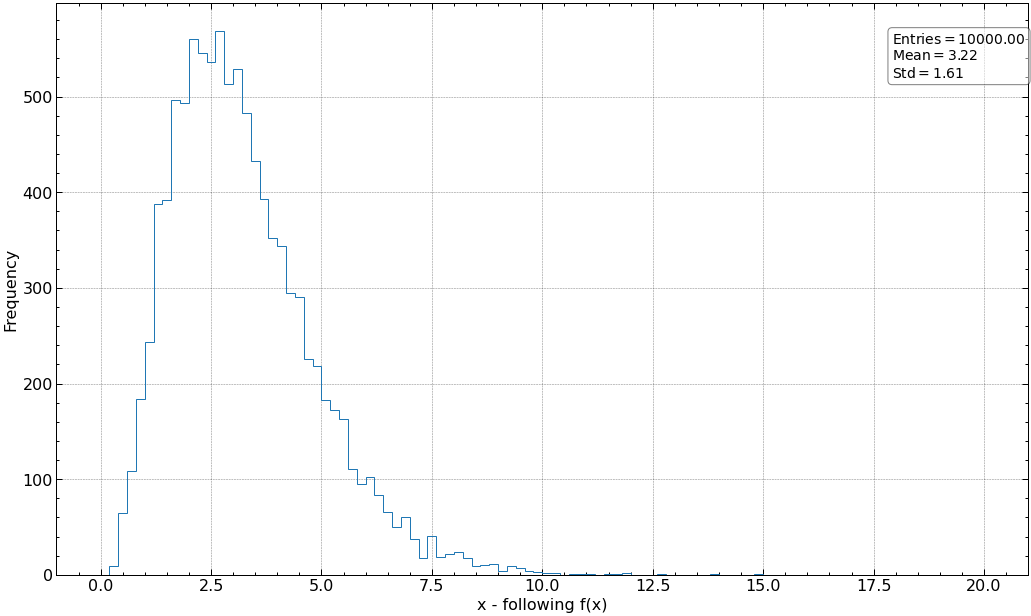

In [80]:
# Init plot object
fig, ax = plt.subplots(figsize=(15, 9))

# Plot generated data
ax.hist(exp_inv, 
        bins = N_bins, 
        range = (xmin_exp, xmax_exp),
        color = blue,
        histtype = 'step'
       )
# Plot labels
ax.set(xlabel = "x - following f(x)", 
       ylabel = "Frequency", 
       xlim = (xmin_exp -1.0 , xmax_exp+1.0))

# Define figure text
textstr = '\n'.join((
    r'$\mathrm{Entries}=%.2f$' % (len(exp_inv), ),
    r'$\mathrm{Mean}=%.2f$' % (exp_inv.mean(), ),
    r'$\mathrm{Std}=%.2f$' % (exp_inv.std(ddof=1), )))

# Plot figure text
props = dict(boxstyle = 'round', 
             facecolor = 'white', 
             edgecolor = 'black', 
             alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.86, 
        0.95, 
        textstr, 
        transform = ax.transAxes, 
        fontsize = 14,
        verticalalignment='top', 
        bbox = props)

fig.tight_layout()

In [81]:
# Binning the data
x3, y3, sigma_y3 = hist_data(exp_inv, 100, 0, 20)

In [82]:
# Fitting
chi2_MC_Gauss = Chi2Regression(func_gauss_norm, x3, y3, sigma_y3)     # Fitting object
chi2_MC_Gauss.errordef = Minuit.LEAST_SQUARES

minuit_MC_Gauss = Minuit(chi2_MC_Gauss, 
                         N = N_points, 
                         mu = 3, 
                         sigma = 1.6)

minuit_MC_Gauss.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1148                       │         Nfcn = 65 (65 total)         │
│ EDM = 2.98e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  20.82e3  │  0.22e3   │            │            │         │         │       │
│ 1 │ mu    │   3.126   │   0.019   │            │            │         │         │       │
│ 2 │ sigma │   1.349   │   0.015   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

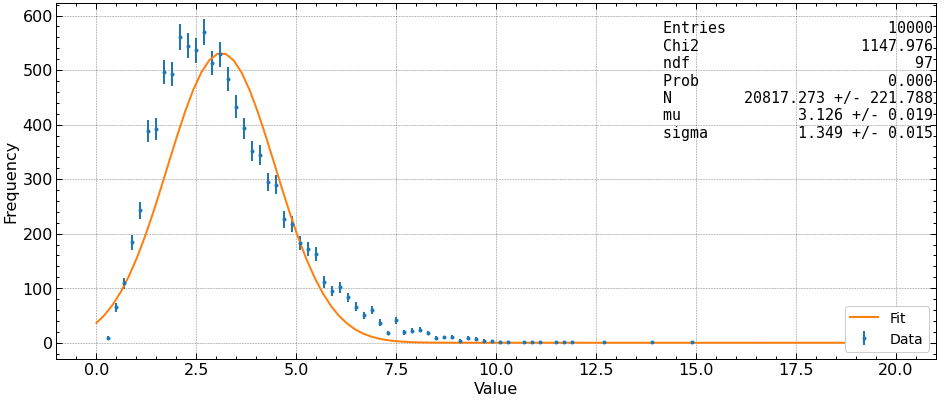

In [83]:
draw_chi2fit(3, exp_inv, xmin_exp, xmax_exp, 
             func_gaussian_alt, minuit_MC_Gauss, N_bins, x3, y3, sigma_y3)

## Exponential Fit

In [84]:
N_exp = 10000     # Number of random points produced
x_exp = r.exponential(np.e, N_exp)

exp_bins = 100
binwidth_exp = np.ptp(x_exp) / exp_bins
exp_min, exp_max = np.min(x_exp), np.max(x_exp)

In [85]:
def exp_pdf(x, N, tau):
    return N * binwidth_exp / tau * np.exp(-x/tau)

In [86]:
# Binning data
x4, y4, sy4 = hist_data(x_exp, exp_bins, exp_min, exp_max)

In [87]:
# Fitting
chi2_exp = Chi2Regression(exp_pdf, x4, y4, sy4)     # Fitting object
chi2_exp.errordef = Minuit.LEAST_SQUARES

minuit_exp = Minuit(chi2_exp, 
                         N = 10000, 
                         tau = 2)

minuit_exp.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 85.13                      │         Nfcn = 38 (38 total)         │
│ EDM = 7.49e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  9.93e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ tau  │   2.693   │   0.027   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

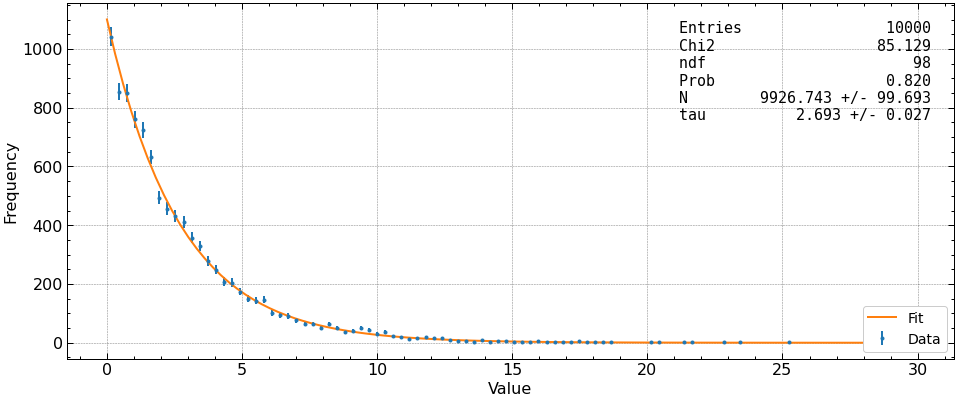

In [88]:
draw_chi2fit(2, x_exp, exp_min, exp_max, exp_pdf, 
             minuit_exp, exp_bins, x4, y4, sy4)

## Power Law Fit

In [89]:
N_pow = 10000     # Number of random points produced
x_pow = r.power(a = 15, 
                size = N_pow)

pow_bins = 100
binwidth_pow = np.ptp(x_pow) / pow_bins
pow_min, pow_max = np.min(x_pow), np.max(x_pow)

In [90]:
def power_pdf(x, N, a, b):
    return N * binwidth_pow / a * np.power(x, b)

In [91]:
# Binning data
x5, y5, sy5 = hist_data(x_pow, pow_bins, pow_min, pow_max)

In [97]:
# Fitting
chi2_pow = Chi2Regression(power_pdf, x5, y5, sy5)     # Fitting object
chi2_pow.errordef = Minuit.LEAST_SQUARES

minuit_pow = Minuit(chi2_pow,
                         N = 10000,
                         a = 4, 
                         b = 1)

minuit_pow.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 59.57                      │        Nfcn = 129 (129 total)        │
│ EDM = 1.17e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  0.11e6   │  0.12e6   │            │            │         │         │       │
│ 1 │ a    │    0.7    │    0.8    │            │            │         │         │       │
│ 2 │ b    │   14.24   │   0.16    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

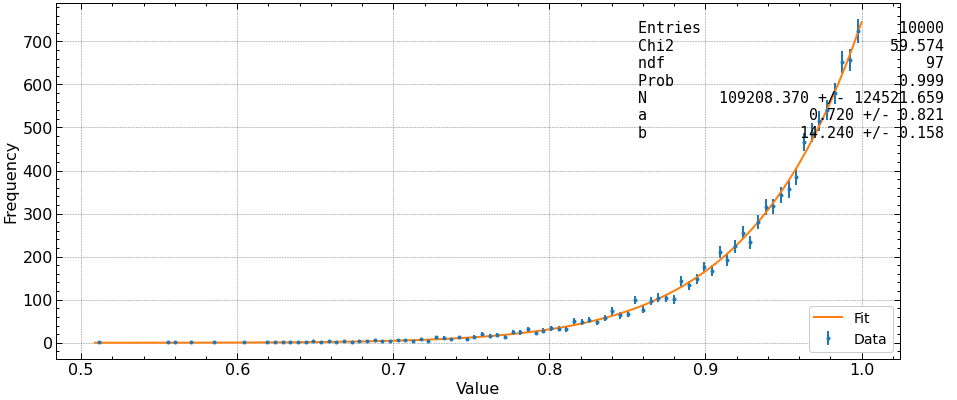

In [98]:
draw_chi2fit(3, x_pow, pow_min, pow_max, power_pdf, 
             minuit_pow, pow_bins, x5, y5, sy5)

In [94]:
stats.anderson(x_exp, dist='expon')

AndersonResult(statistic=0.8263378287992964, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [61]:
# Null is accepted at all significance levels as test statistic is lower than critical values